In [1]:
import numpy as np
import librosa

In [18]:
%matplotlib inline

In [10]:
class GridCircle():
    '''
    Creates a grid on the circle.
    Parameters
    ----------
    n_points: int, optional
        The number of uniformly spaced points in the grid.
    azimuth: ndarray, optional
        An array of azimuth (in radians) to use for grid locations. Overrides n_points.
    '''

    def __init__(self, n_points=360, azimuth=None, center=[0,0], r = 5):
        self.n_points = n_points
        self.values = None
        self.cartesian = np.zeros((3,n_points))
        self.spherical = np.zeros((2,n_points))
        self.x = self.cartesian[0,:]
        self.y = self.cartesian[1,:]

        self.azimuth = self.spherical[0,:]
        self.colatitude = self.spherical[1,:]

        
        
        if azimuth is not None:

            if azimuth.ndim != 1:
                raise ValueError("Azimuth must be a 1D ndarray.")

            azimuth = np.sort(azimuth)

            n_points = azimuth.shape[0]

        else:
            azimuth = np.linspace(np.pi, 2*np.pi, n_points, endpoint=False)


        # spherical coordinates
        self.azimuth[:] = azimuth
        self.colatitude[:] = np.pi / 2  # Fix colatitude to ecuador

        # cartesian coordinates
        self.x[:] = center[0] + r *np.cos(azimuth)
        self.y[:] = center[1] + r*np.sin(azimuth)

    def apply(self, func, spherical=False):

        if spherical:
            self.values = func(self.azimuth)
        else:
            self.values = func(self.x, self.y)
        
    def set_values(self, vals):

        vals = np.array(vals)

        if vals.ndim == 0:
            self.values = np.ones(self.n_points) * vals

        else:
            if vals.shape != (self.n_points,):
                raise ValueError('Values should be a scalar or a 1D ndarray of the grid size.')

            self.values = vals
            

    def find_peaks(self, k=1):

        # make circular
        #val_ext = np.append(self.values ,self.values[:10])

        # run peak finding
        #indexes = detect_peaks(val_ext, show=False) % self.n_points
        #candidates = np.unique(indexes)  # get rid of duplicates, if any

        # Select k largest
        #peaks = self.values[candidates]
        #max_idx = np.argsort(peaks)[-k:]

        # return the indices of peaks found
        #return candidates[max_idx]
        return np.argsort(self.values)[-1]
    
    def plot(self, mark_peaks=0):
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            import warnings
            warnings.warn('Matplotlib is required for plotting')
            return
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='polar')
        pts = np.append(self.azimuth, self.azimuth[0])
        vals = np.append(self.values, self.values[0])
        ax.plot(pts, vals, '-')

        if mark_peaks > 0:
            idx = self.find_peaks(k=mark_peaks)
            ax.plot(pts[idx], vals[idx], 'ro')


In [11]:
class SRP():
    
    def __init__(self,nfft, hop_len, Mic, grid, sample_rate, c=343): 
        """
        
        nfft: int
                the FFT length
        Mic: ndarray
            contains the locations of the microphones in the columns of the array            
        grid: Grid object
        sample_rate: int
                the sampling frequency of the input signal
        c: float
                the speed of sound       
        
         X: numpy array
            Set of signals in the frequency (RFFT) domain for current 
            frame. Size should be M x F x S, where M should correspond to the 
            number of microphones, F to nfft/2+1, and S to the number of snapshots 
            (user-defined). It is recommended to have S >> M.
                
        """
        
        self.nfft = nfft
        self.hop_len = hop_len
        
        self.x = None
        self.X = None
        
        self.M = Mic
        self.grid = grid
        
        self.sr = sample_rate
        self.c = c
    
    def set_sigs(self, sigs):
        self.x = sigs
        self.X = []
        frames = self.x.shape[1]//self.hop_len-1
        for i in range(frames): #TO-DO: change the number 
            self.X.append(np.fft.rfft(self.x[:,i*self.hop_len:i*self.hop_len+self.nfft]))
        
        self.X = np.array(self.X)
        self.X = np.moveaxis(self.X, 0, -1)
    
    def locate_sources(self, freq_range=[0.0, 10000.0]):
        """
        Locate source(s) using corresponding algorithm.
        Parameters
        ----------
        freq_range: list of floats, length 2
            Frequency range on which to run DoA: [fmin, fmax].
      
        """

        n_m = self.M.shape[1]
        num_pairs = n_m*(n_m-1)/2
        num_snap = self.X.shape[2]
        max_bin = self.nfft//2 + 1

        # frequency bins on which to apply DOA
        freq_range = [int(np.round(f / self.sr * self.nfft)) for f in freq_range]
        freq_bins = np.arange(freq_range[0], freq_range[1], dtype=np.int)

        freq_bins = freq_bins[freq_bins < max_bin]
        freq_bins = freq_bins[freq_bins >= 0]
        #freq_hz = freq_bins * float(fs) / float(nfft)
        num_freq = len(freq_bins)
    
        #print("freq bins nums")
        #print(num_freq)
        
        # search for DoA according to SPR
        
        # initialize the grid value to zero
        grid.set_values(0.)

        # Run the SPR
        ones = np.ones(self.M.shape[1])
        srp_cost = np.zeros(self.grid.n_points)
        
        # apply PHAT weighting
        tol = 1e-14
        absX = np.abs(self.X)
        absX[absX < tol] = tol

        pX = self.X /np.sqrt(absX)
        #pX = X
        
        #generalized cross correlation for each freq 
        CC = []
        for k in freq_bins:
            CC.append(np.dot(pX[:,k,:], np.conj(pX[:,k,:]).T))
        CC = np.array(CC)

        mode_vecs = self.get_mode_vec()
        
        for n in range(grid.n_points):

            # get the mode vector axis: (frequency, microphones)
            mode_vec = mode_vecs[freq_bins,:,n]

            # compute the outer product along the microphone axis
            mode_mat = np.conj(mode_vec[:,:,None]) * mode_vec[:,None,:]

            # multiply covariance by mode vectors and sum over the frequencies
            R = np.sum(CC * mode_mat, axis=0)

            # Now sum over all distince microphone pairs
            sum_val = np.inner(ones, np.dot(np.triu(R, 1), ones))

            # Finally normalize
            srp_cost[n] = np.abs(sum_val)/num_snap/num_freq/num_pairs
        
        self.grid.set_values(srp_cost)
        src_idx = self.grid.find_peaks(k=1)
        azimuth_recon = self.grid.azimuth[src_idx]
        
        return azimuth_recon/np.pi*180
        
    def get_mode_vec(self, mode='far'):
        '''
        mode: string, optional
            specify if the mode vectors are far- or near-field
        '''       
        # short hands for propagation vectors, upped to 3D array
        p_x = self.grid.x[None, None, :]
        p_y = self.grid.y[None, None, :]

        # short hands for microphone locations, upped to 3D array
        r_x = self.M[0, None, :, None]
        r_y = self.M[1, None, :, None]

        # Here we compute the time of flights from source candidate locations
        # to microphones
        if mode == 'near':
            # distance
            dist = np.sqrt((p_x - r_x) ** 2 + (p_y - r_y) ** 2)

        elif mode == 'far':
            # projection
            dist = (p_x * r_x) + (p_y * r_y) 

        # shape (1, num_mics, grid_size)
        tau = dist / self.c

        # shape (nfft // 2 + 1) 
        omega = 2 * np.pi * self.sr * np.arange(self.nfft // 2 + 1) / self.nfft

        mode_vec = np.exp(1j * omega[:, None, None] * tau)

        return mode_vec

In [12]:
#main function starts here

x_M = list(np.array([-0.56, -0.42, -0.28, -0.14, -0.07, -0.035, 0, 0.035, 0.07, 0.105, 0.14, 0.21, 0.28, 0.42, 0.56]))
y_M = [0]*15
Mic = np.array([x_M, y_M])

In [13]:
c = 343
center = [0,0]
radius = 2
grid = GridCircle(n_points=360, center = center, r = radius)

In [14]:
sigs = []
file_name = "mic_audiodata_60_"
for i in range(15):
    f_n = file_name + str(i+1) + ".wav"
    sig, sr = librosa.load(f_n, sr = 16000)
    sigs.append(sig)

In [15]:
mic_order = [6, 5, 4, 15, 11, 13, 14, 12, 10, 9, 8, 7, 3, 2, 1]
ordered_sigs = []
for i in range(15):
    ind = mic_order[i]
    sig = sigs[ind-1]
    ordered_sigs.append(sig)
ordered_sigs = np.array(ordered_sigs)

In [16]:
NFFT = 768
HOP_LEN = 384
sample_rate = 16000
srp = SRP(NFFT, HOP_LEN, Mic, grid, sample_rate, c)

In [28]:
chunk_len = 12800
chunk_num = ordered_sigs.shape[1]//chunk_len

for i in range(chunk_num):
    chunk_sigs = ordered_sigs[:,i*chunk_len : i*chunk_len+ chunk_len]

    srp.set_sigs(chunk_sigs)
    angle = srp.locate_sources()
    print(angle)
    if i == 7:
        break
# the result should be stable, but currently it can be as is

270.0
281.5
284.5
286.5
294.5
285.0
285.5
285.5


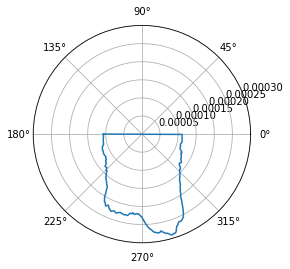

In [27]:
grid.plot()

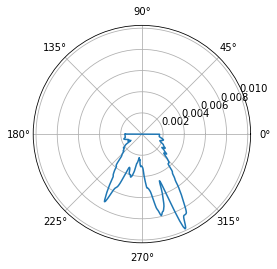

In [23]:
grid.plot()

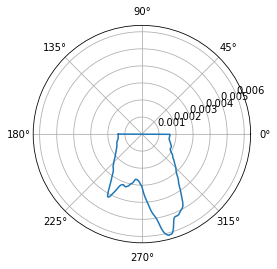

In [25]:
grid.plot()

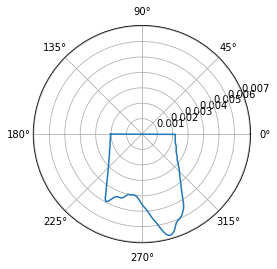

In [29]:
grid.plot()